# Lecture : Graph Generation Models

## Lab 03 : Wasserstein generative adversarial networks (WGAN) for mixture of Gaussians

### Xavier Bresson


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/11_Graph_Generation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings
import os, datetime

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.2.2
NVIDIA RTX A5000
cuda:2


# Create artifical dataset of mixture of Gaussians

num_x, range_x, step_x, x :  100 20 0.40404040404040403 torch.Size([100])
num_gaussians :  2
train_data, bs, num_batch :  torch.Size([4000, 100]) 100 40
train_data :  torch.Size([4000, 100])
max, min, mean :  tensor(1.) tensor(-1.) tensor(-0.7510)


<Figure size 640x480 with 0 Axes>

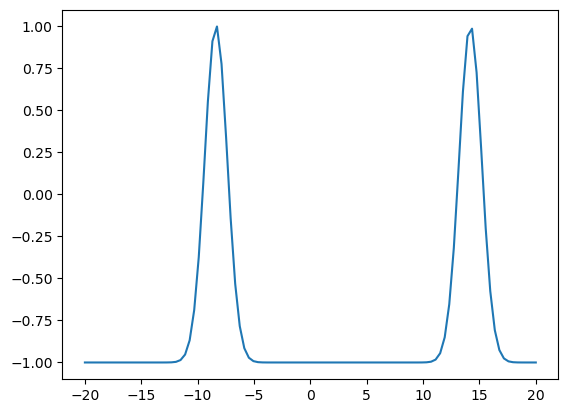

<Figure size 640x480 with 0 Axes>

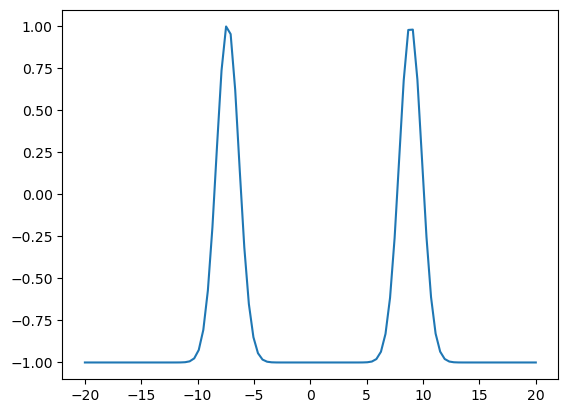

In [53]:
# Parameters of the mixture of Gaussians
num_data = 4000
num_x = 100
range_x = 20
step_x = 2 * range_x / (num_x - 1)
x = torch.arange(-range_x,range_x+step_x,step_x)
print('num_x, range_x, step_x, x : ',num_x, range_x, step_x, x.size())
num_gaussians = 2
print('num_gaussians : ', num_gaussians)
train_data = torch.zeros(num_data, num_x)
bs = 100
num_batch = num_data//bs
print('train_data, bs, num_batch : ', train_data.size(), bs, num_batch)

for k in range(num_batch):
    mu = torch.zeros(num_gaussians, bs)
    mu[0,:] = torch.FloatTensor(bs).uniform_(-15, -5)
    mu[1,:] = torch.FloatTensor(bs).uniform_(5, 15)   
    mu_batch = mu.unsqueeze(2)
    sigma = torch.ones(num_gaussians, bs)
    sigma_batch = sigma.unsqueeze(2)
    x_batch = x.repeat(num_gaussians, bs, 1)
    p = torch.exp( - (x_batch - mu_batch)**2 / (2* sigma_batch**2) ) / torch.sqrt( 2* torch.pi* sigma_batch**2 )
    p = p.sum(0); p /= p.sum(1).unsqueeze(1)
    p = ( p - p.min(1)[0].unsqueeze(1) ) / ( p.max(1)[0].unsqueeze(1) - p.min(1)[0].unsqueeze(1) )
    p = 2 * ( p - 0.5 )
    train_data[k*bs:(k+1)*bs, :] = p
print('train_data : ',train_data.size())
print('max, min, mean : ',train_data.max(), train_data.min(), train_data.mean())

plt.figure(2)
plt.figure(dpi=100)
plt.plot(x, train_data[0])
plt.show()
plt.figure(3)
plt.figure(dpi=100)
plt.plot(x, train_data[1])
plt.show()


# WGAN [1,2] with Transformers [3]

[1] Goodfellow et-al, Generative Adversarial Networks, 2014, https://arxiv.org/pdf/1406.2661  
[2] Gulrajani et-al, Improved Training of Wasserstein GANs, 2017, https://arxiv.org/pdf/1704.00028  
[3] Vaswani et-al, Attention Is All You Need, 2017, https://arxiv.org/pdf/1706.03762


In [54]:
# Global constants
N = train_data.size(0) # number of training data
n = train_data.size(1) # number of elements in the line 
print('N, n : ', N, n)

dz = 16 # number of dimensions for the compressed representation
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers_discriminator = 2 # number of transformer discriminator layers
num_layers_generator = 2 # number of transformer generator layers
drop = 0.0 # dropout value
dropout_dis = 0.05 # dropout value for the discriminator network
bs = 50 # batch size
print('dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs : ', \
      dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs)


N, n :  4000 100
dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs :  16 4 128 2 2 0.0 0.05 50


In [55]:
# Define WGAN architecture with Transformers
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
    def forward(self, x):
        Q = self.Q(x)      # [bs, n, d_head]
        K = self.K(x)      # [bs, n, d_head]
        V = self.V(x)      # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        Att = (Q * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)        # [bs, n, n]
        Att = self.drop_att(Att) # [bs, n, d_head]
        x = Att @ V              # [bs, n, d_head]
        return x

class MHA(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
    def forward(self, x):
        x_MHA = []  
        for head in self.heads:
            x_HA = head(x)                    # [bs, n, d_head]
            x_MHA.append(x_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        return x

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.LeakyReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
        self.mu = nn.Linear(d, d, bias=True)
    def forward(self, x):
        x_in = x                        # [bs, n, d]
        x = self.LNx(x)                 # [bs, n, d]
        x_MHA = self.MHA(x)             # [bs, n, d]
        x = x_in + x_MHA                # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        return x

class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_z = nn.Linear(dz, n*d)
        self.ln_h = nn.LayerNorm(n*d)
        self.gt_gen_layers = nn.ModuleList( [BlockGT(d, num_heads) for k in range(num_layers_generator)] )  
        self.ln_final = nn.LayerNorm(d)  
        self.linear_final = nn.Linear(d, 1)
    def forward(self, z, pe):  
        # input layer
        h = self.linear_z(z)  # [bs, n*d] 
        h = self.ln_h(h)      # [bs, n*d] 
        h = nn.LeakyReLU()(h) # [bs, n*d] 
        bs2 = h.size(0)
        h = h.view(bs2, n, d) # [bs, n, d]
        h = h + pe[:bs2,:,:]  # [bs, n, d]
        # L layers
        for gt_gen_layer in self.gt_gen_layers:
            h = gt_gen_layer(h)            # [bs, n, d]
        # output    
        h = nn.LeakyReLU()(h)              # [bs, n, d] 
        h = self.ln_final(h)               # [bs, n, d] 
        h = self.linear_final(h).squeeze() # [bs, n] 
        return h

class discriminator(nn.Module):
    def __init__(self):
        super().__init__()   
        self.h_emb = nn.Linear(1, d)
        self.gt_dis_layers = nn.ModuleList( [BlockGT(d, num_heads) for k in range(num_layers_discriminator)] )  
        self.dp_dis_layers = nn.ModuleList( [nn.Dropout(p=dropout_dis) for k in range(num_layers_discriminator)] )  
        self.linear_out = nn.Linear(n*d, 1)   
    def forward(self, h, pe): 
        # input layer
        h = self.h_emb(h.unsqueeze(2)) # [bs, n, d]
        h = h + pe                     # [bs, n, d] 
        # L layers
        for gt_dis_layer, dp_dis_layer in zip(self.gt_dis_layers, self.dp_dis_layers): 
            h = gt_dis_layer(h)        # [bs, n, d]
            h = dp_dis_layer(h)        # [bs, n, d]
        # output
        h = h.contiguous().view(bs, n*d) # [bs, n*d]
        h = self.linear_out(h)           # [bs, 1]
        return h

class WGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.pe_x = nn.Embedding(n, d)
        self.generator = generator()
        self.discriminator = discriminator()
    def forward_gen(self, z):
        pe = torch.arange(0,n).to(device).repeat(bs,1) # [bs, n] 
        pe = self.pe_x(pe)                             # [bs, n, d] 
        g_z = self.generator(z, pe)                    # [bs, n] 
        return g_z
    def forward_dis(self, h):
        pe = torch.arange(0,n).to(device).repeat(bs,1) # [bs, n] 
        pe = self.pe_x(pe)                             # [bs, n, d] 
        d_h = self.discriminator(h, pe)                # [bs, 1]
        return d_h


# Instantiate the network
net = WGAN()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
list_param = []
for p in net.generator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_gen = nn.ParameterList(list_param)
list_param = []
for p in net.discriminator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_dis = nn.ParameterList(list_param)
init_lr = 0.001
optimizer_g = torch.optim.Adam(params_gen, lr=init_lr)
optimizer_d = torch.optim.Adam(params_dis, lr=init_lr)

idx_data = torch.LongTensor(bs).random_(0,N)
x_real = train_data[idx_data,:].to(device) # [bs, n]
print('x_real',x_real.size())
z = torch.rand(bs, dz).to(device) # [bs, dz]
print('z',z.size())

x_fake = net.forward_gen(z) # [bs, n]
print('x_fake',x_fake.size())
fake_discr = net.forward_dis(x_fake) # [bs, 1]    
real_discr = net.forward_dis(x_real) # [bs, 1]
print('fake_discr',fake_discr.size())
print('real_discr',real_discr.size())
loss = fake_discr.mean() - real_discr.mean()

epsilon = torch.FloatTensor(bs, 1).uniform_(0, 1).to(device)
x_hat = epsilon * x_fake + (1 - epsilon) * x_real
xhat_discr = net.forward_dis(x_hat)
grads = torch.autograd.grad(xhat_discr, x_hat, grad_outputs=torch.ones_like(xhat_discr), create_graph=True)[0]
penalty = ((torch.sqrt((grads ** 2).sum(1)) - 1) ** 2).mean()
loss = loss + 10 * penalty

optimizer_d.zero_grad()
loss.backward()
optimizer_d.step()

z = torch.rand(bs, dz).to(device) # [bs, dz]
loss = - net.forward_dis(net.forward_gen(z)).mean()
optimizer_g.zero_grad()
loss.backward()
optimizer_g.step()


Number of parameters: 1128578 (1.13 million)
x_real torch.Size([50, 100])
z torch.Size([50, 16])
x_fake torch.Size([50, 100])
fake_discr torch.Size([50, 1])
real_discr torch.Size([50, 1])


Number of parameters: 1128578 (1.13 million)
dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs :  16 4 128 2 2 0.0 0.05 50
epoch= 0 	 time= 0.1373 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.03143 	 loss_g= 2.08320
epoch= 1 	 time= 0.2768 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.03025 	 loss_g= 1.06066
epoch= 2 	 time= 0.4151 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.03815 	 loss_g= -0.6792
epoch= 3 	 time= 0.5536 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.03986 	 loss_g= -2.3392
epoch= 4 	 time= 0.6961 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.03704 	 loss_g= -4.9986
epoch= 5 	 time= 0.8383 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.03231 	 loss_g= -7.0449
epoch= 6 	 time= 0.9804 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.02487 	 loss_g= -10.374
epoch= 7 	 time= 1.1219 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.02667 	 loss_g= -13.390
epoch= 8 	 time= 1.2635 min 	 lr_d= 0.0

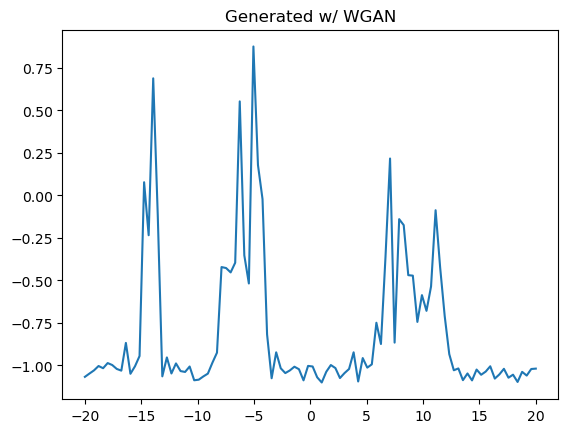

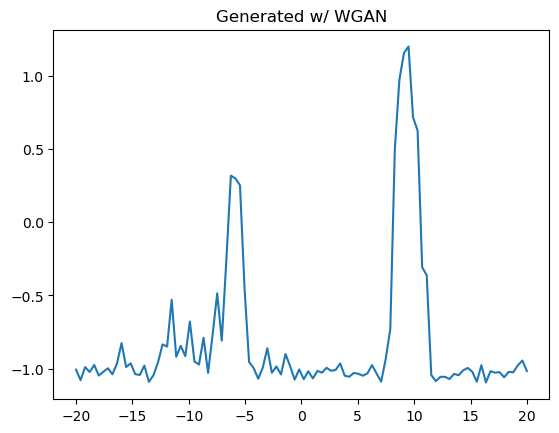

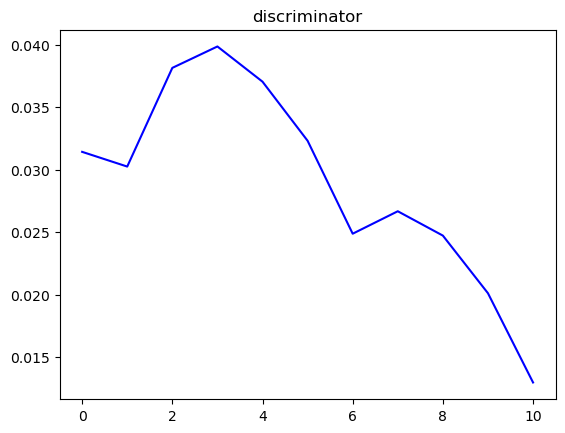

epoch= 11 	 time= 1.6926 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.02290 	 loss_g= -24.340
epoch= 12 	 time= 1.8344 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.01884 	 loss_g= -27.566
epoch= 13 	 time= 1.9764 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.01554 	 loss_g= -30.841
epoch= 14 	 time= 2.1190 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.01917 	 loss_g= -34.515
epoch= 15 	 time= 2.2611 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00772 	 loss_g= -38.170
epoch= 16 	 time= 2.4033 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00991 	 loss_g= -43.070
epoch= 17 	 time= 2.5449 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00874 	 loss_g= -47.548
epoch= 18 	 time= 2.6869 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00806 	 loss_g= -51.635
epoch= 19 	 time= 2.8290 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00891 	 loss_g= -54.511
epoch= 20 	 time= 2.9708 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00100 	 loss_g

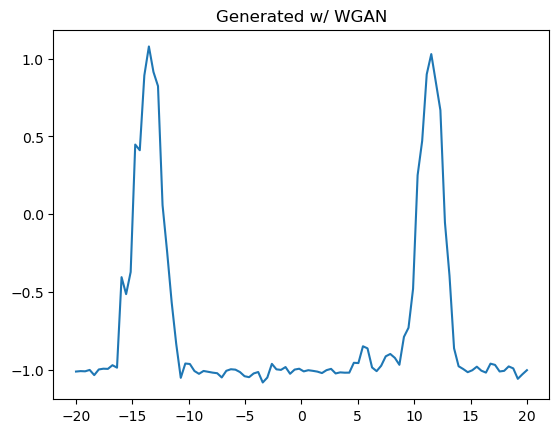

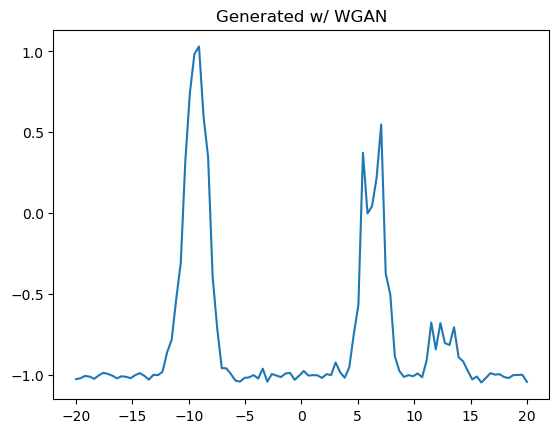

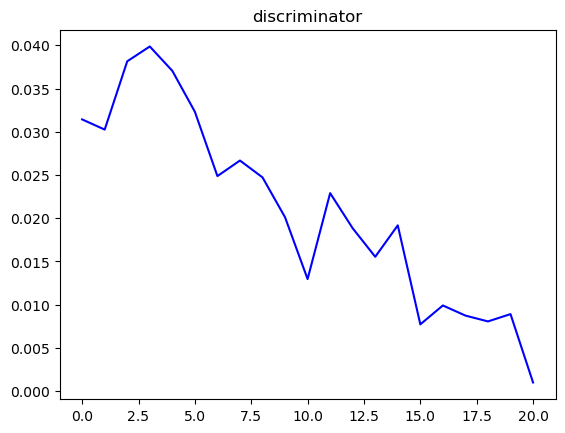

epoch= 21 	 time= 3.1187 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00313 	 loss_g= -62.736
epoch= 22 	 time= 3.2605 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00413 	 loss_g= -66.715
epoch= 23 	 time= 3.4024 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00279 	 loss_g= -69.953
epoch= 24 	 time= 3.5444 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00784 	 loss_g= -74.239
epoch= 25 	 time= 3.6861 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00622 	 loss_g= -79.418
epoch= 26 	 time= 3.8278 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00276 	 loss_g= -83.367
epoch= 27 	 time= 3.9701 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00121 	 loss_g= -87.893
epoch= 28 	 time= 4.1124 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00526 	 loss_g= -92.007
epoch= 29 	 time= 4.2542 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= -0.0005 	 loss_g= -94.872
epoch= 30 	 time= 4.3958 min 	 lr_d= 0.0003000 	 lr_g= 0.0003000 	 loss_d= 0.00569 	 loss_g

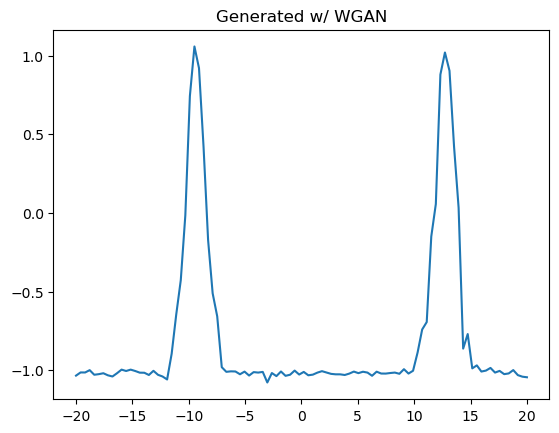

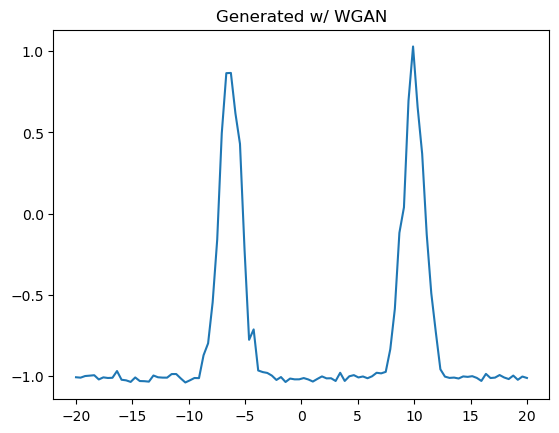

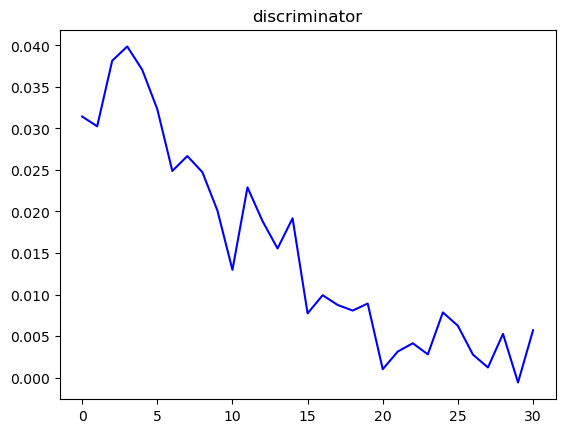

epoch= 31 	 time= 4.5432 min 	 lr_d= 0.0002850 	 lr_g= 0.0002850 	 loss_d= 0.00032 	 loss_g= -103.10
epoch= 32 	 time= 4.6843 min 	 lr_d= 0.0002850 	 lr_g= 0.0002850 	 loss_d= 0.00248 	 loss_g= -106.37
epoch= 33 	 time= 4.8261 min 	 lr_d= 0.0002707 	 lr_g= 0.0002707 	 loss_d= 0.00119 	 loss_g= -110.37
epoch= 34 	 time= 4.9656 min 	 lr_d= 0.0002707 	 lr_g= 0.0002707 	 loss_d= 0.00318 	 loss_g= -114.47
epoch= 35 	 time= 5.1072 min 	 lr_d= 0.0002572 	 lr_g= 0.0002572 	 loss_d= 0.00044 	 loss_g= -120.35
epoch= 36 	 time= 5.2493 min 	 lr_d= 0.0002572 	 lr_g= 0.0002572 	 loss_d= -0.0031 	 loss_g= -124.66
epoch= 37 	 time= 5.3910 min 	 lr_d= 0.0002572 	 lr_g= 0.0002572 	 loss_d= 0.00098 	 loss_g= -127.77
epoch= 38 	 time= 5.5336 min 	 lr_d= 0.0002444 	 lr_g= 0.0002444 	 loss_d= 0.00206 	 loss_g= -130.33
epoch= 39 	 time= 5.6757 min 	 lr_d= 0.0002444 	 lr_g= 0.0002444 	 loss_d= 0.00193 	 loss_g= -134.26
epoch= 40 	 time= 5.8171 min 	 lr_d= 0.0002321 	 lr_g= 0.0002321 	 loss_d= 0.00739 	 loss_g

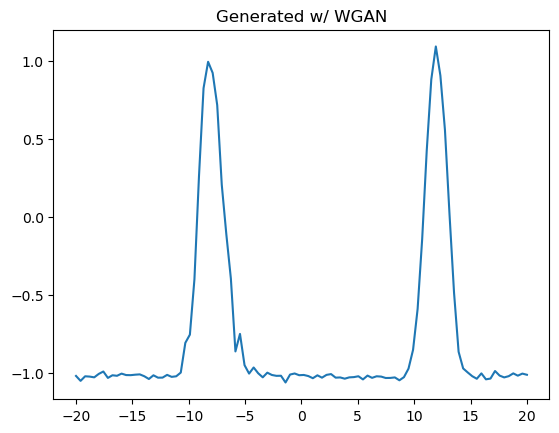

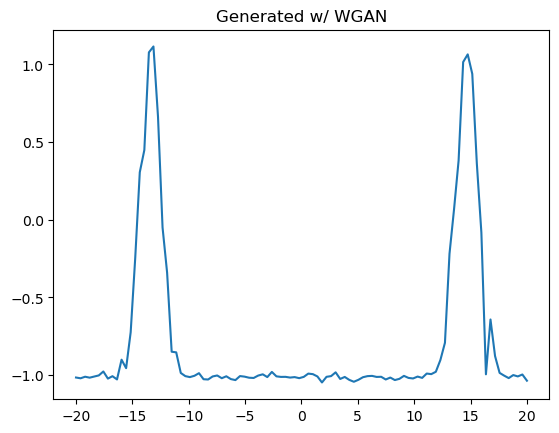

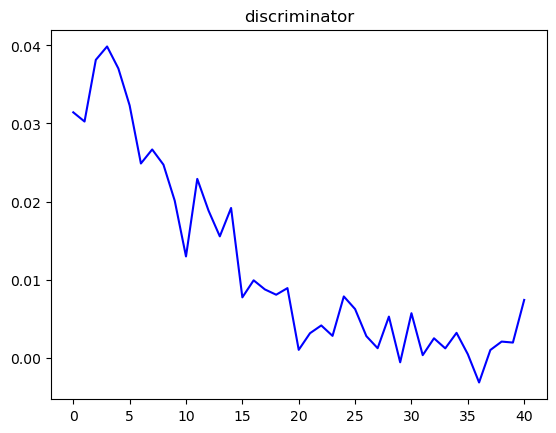

epoch= 41 	 time= 5.9624 min 	 lr_d= 0.0002321 	 lr_g= 0.0002321 	 loss_d= -0.0005 	 loss_g= -139.14
epoch= 42 	 time= 6.0984 min 	 lr_d= 0.0002321 	 lr_g= 0.0002321 	 loss_d= -0.0074 	 loss_g= -141.79
epoch= 43 	 time= 6.2336 min 	 lr_d= 0.0002321 	 lr_g= 0.0002321 	 loss_d= -0.0025 	 loss_g= -145.36
epoch= 44 	 time= 6.3686 min 	 lr_d= 0.0002205 	 lr_g= 0.0002205 	 loss_d= 0.00313 	 loss_g= -150.62
epoch= 45 	 time= 6.5042 min 	 lr_d= 0.0002205 	 lr_g= 0.0002205 	 loss_d= 0.00337 	 loss_g= -153.34
epoch= 46 	 time= 6.6391 min 	 lr_d= 0.0002095 	 lr_g= 0.0002095 	 loss_d= -0.0007 	 loss_g= -157.14
epoch= 47 	 time= 6.7745 min 	 lr_d= 0.0002095 	 lr_g= 0.0002095 	 loss_d= 0.00860 	 loss_g= -161.19
epoch= 48 	 time= 6.9097 min 	 lr_d= 0.0002095 	 lr_g= 0.0002095 	 loss_d= -0.0081 	 loss_g= -164.72
epoch= 49 	 time= 7.0453 min 	 lr_d= 0.0002095 	 lr_g= 0.0002095 	 loss_d= -0.0001 	 loss_g= -168.03
epoch= 50 	 time= 7.1802 min 	 lr_d= 0.0001990 	 lr_g= 0.0001990 	 loss_d= 0.00173 	 loss_g

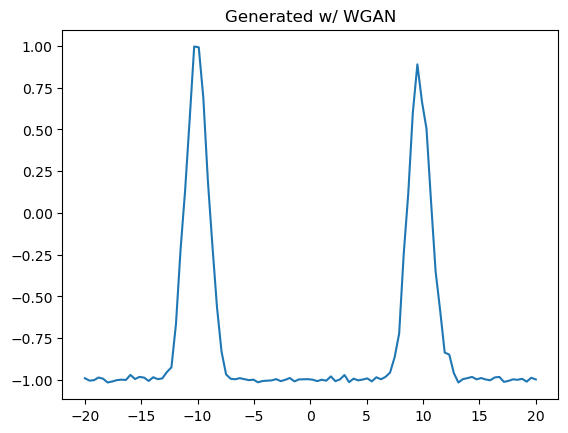

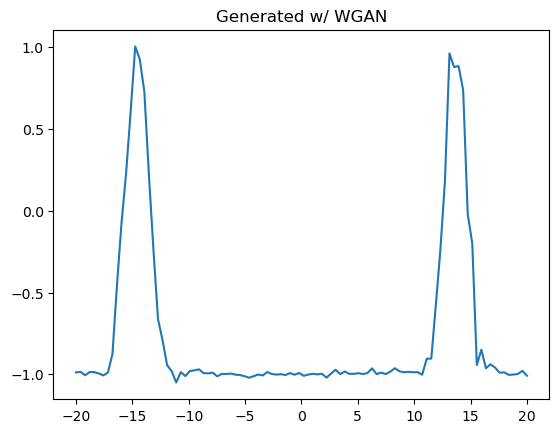

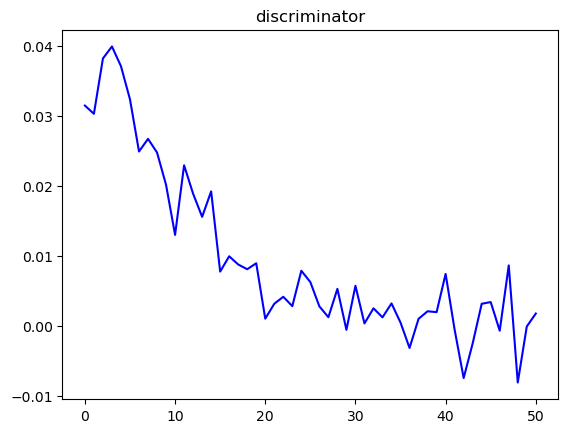

epoch= 51 	 time= 7.3218 min 	 lr_d= 0.0001990 	 lr_g= 0.0001990 	 loss_d= 0.00507 	 loss_g= -175.78
epoch= 52 	 time= 7.4567 min 	 lr_d= 0.0001891 	 lr_g= 0.0001891 	 loss_d= -0.0012 	 loss_g= -179.40
epoch= 53 	 time= 7.5920 min 	 lr_d= 0.0001891 	 lr_g= 0.0001891 	 loss_d= -0.0025 	 loss_g= -180.83
epoch= 54 	 time= 7.7276 min 	 lr_d= 0.0001796 	 lr_g= 0.0001796 	 loss_d= -0.0034 	 loss_g= -183.30
epoch= 55 	 time= 7.8628 min 	 lr_d= 0.0001796 	 lr_g= 0.0001796 	 loss_d= -0.0022 	 loss_g= -185.84
epoch= 56 	 time= 8.0064 min 	 lr_d= 0.0001706 	 lr_g= 0.0001706 	 loss_d= -0.0025 	 loss_g= -188.88
epoch= 57 	 time= 8.1458 min 	 lr_d= 0.0001706 	 lr_g= 0.0001706 	 loss_d= -0.0100 	 loss_g= -191.49
epoch= 58 	 time= 8.2846 min 	 lr_d= 0.0001706 	 lr_g= 0.0001706 	 loss_d= 0.00658 	 loss_g= -194.30
epoch= 59 	 time= 8.4255 min 	 lr_d= 0.0001621 	 lr_g= 0.0001621 	 loss_d= 0.00170 	 loss_g= -196.72
epoch= 60 	 time= 8.5637 min 	 lr_d= 0.0001621 	 lr_g= 0.0001621 	 loss_d= 0.01082 	 loss_g

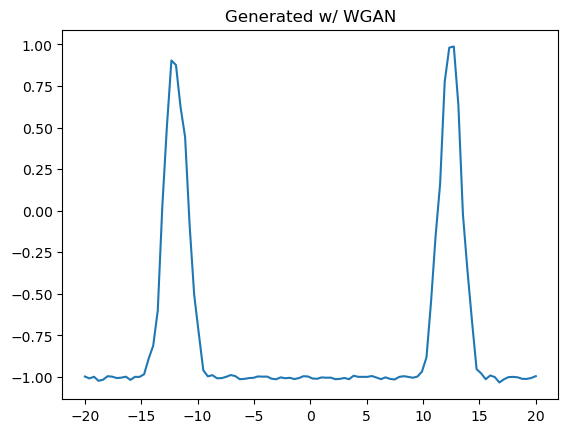

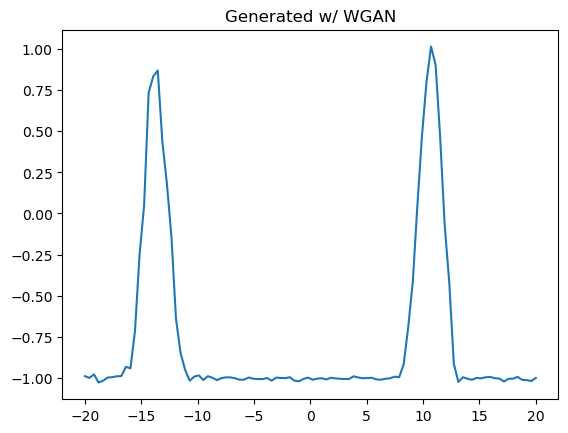

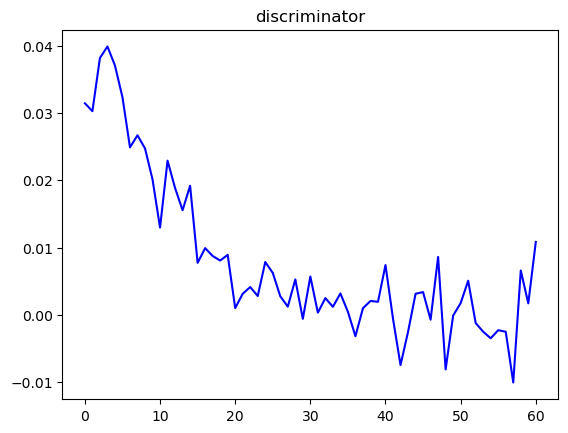

epoch= 61 	 time= 8.7148 min 	 lr_d= 0.0001540 	 lr_g= 0.0001540 	 loss_d= 3.28608 	 loss_g= -201.21
epoch= 62 	 time= 8.8558 min 	 lr_d= 0.0001540 	 lr_g= 0.0001540 	 loss_d= 0.00413 	 loss_g= -202.62
epoch= 63 	 time= 8.9946 min 	 lr_d= 0.0001463 	 lr_g= 0.0001463 	 loss_d= 0.00417 	 loss_g= -204.61
epoch= 64 	 time= 9.1362 min 	 lr_d= 0.0001463 	 lr_g= 0.0001463 	 loss_d= 0.00022 	 loss_g= -206.64
epoch= 65 	 time= 9.2767 min 	 lr_d= 0.0001390 	 lr_g= 0.0001390 	 loss_d= 0.00164 	 loss_g= -209.08
epoch= 66 	 time= 9.4145 min 	 lr_d= 0.0001390 	 lr_g= 0.0001390 	 loss_d= -0.0037 	 loss_g= -210.27
epoch= 67 	 time= 9.5537 min 	 lr_d= 0.0001320 	 lr_g= 0.0001320 	 loss_d= 0.00221 	 loss_g= -212.50
epoch= 68 	 time= 9.6937 min 	 lr_d= 0.0001320 	 lr_g= 0.0001320 	 loss_d= 0.00078 	 loss_g= -214.81
epoch= 69 	 time= 9.8331 min 	 lr_d= 0.0001254 	 lr_g= 0.0001254 	 loss_d= 0.00449 	 loss_g= -216.94
epoch= 70 	 time= 9.9731 min 	 lr_d= 0.0001254 	 lr_g= 0.0001254 	 loss_d= -0.0053 	 loss_g

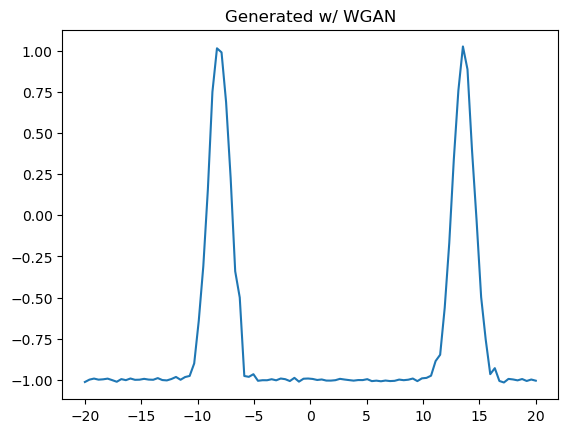

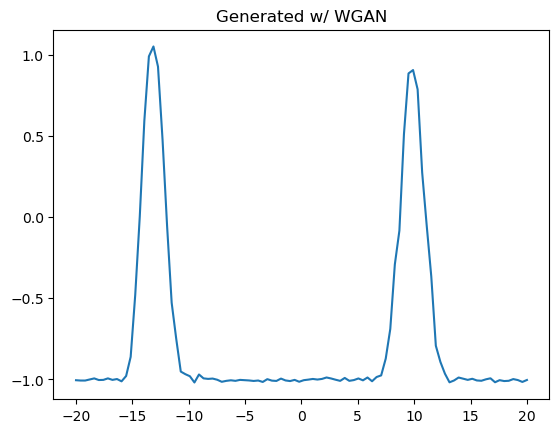

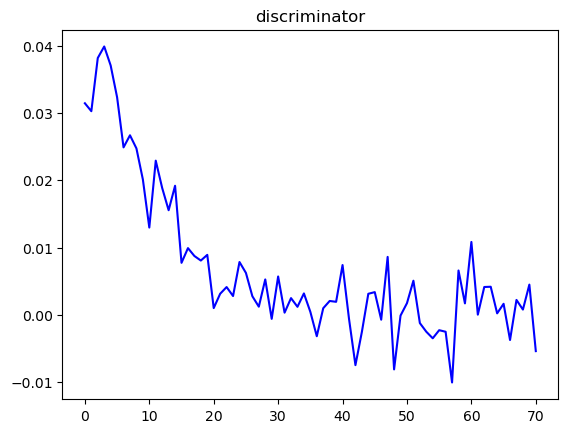

epoch= 71 	 time= 10.118 min 	 lr_d= 0.0001192 	 lr_g= 0.0001192 	 loss_d= 0.00030 	 loss_g= -220.60
epoch= 72 	 time= 10.256 min 	 lr_d= 0.0001192 	 lr_g= 0.0001192 	 loss_d= -0.0065 	 loss_g= -223.13
epoch= 73 	 time= 10.394 min 	 lr_d= 0.0001132 	 lr_g= 0.0001132 	 loss_d= 0.00976 	 loss_g= -225.90
epoch= 74 	 time= 10.533 min 	 lr_d= 0.0001132 	 lr_g= 0.0001132 	 loss_d= -0.0054 	 loss_g= -226.48
epoch= 75 	 time= 10.673 min 	 lr_d= 0.0001075 	 lr_g= 0.0001075 	 loss_d= 0.01234 	 loss_g= -228.06
epoch= 76 	 time= 10.813 min 	 lr_d= 0.0001075 	 lr_g= 0.0001075 	 loss_d= 0.00109 	 loss_g= -229.30
epoch= 77 	 time= 10.953 min 	 lr_d= 0.0001022 	 lr_g= 0.0001022 	 loss_d= -0.0062 	 loss_g= -230.69
epoch= 78 	 time= 11.093 min 	 lr_d= 0.0001022 	 lr_g= 0.0001022 	 loss_d= 0.00088 	 loss_g= -232.35
epoch= 79 	 time= 11.231 min 	 lr_d= 0.0000971 	 lr_g= 0.0000971 	 loss_d= -0.0074 	 loss_g= -233.72
epoch= 80 	 time= 11.371 min 	 lr_d= 0.0000971 	 lr_g= 0.0000971 	 loss_d= 0.00088 	 loss_g

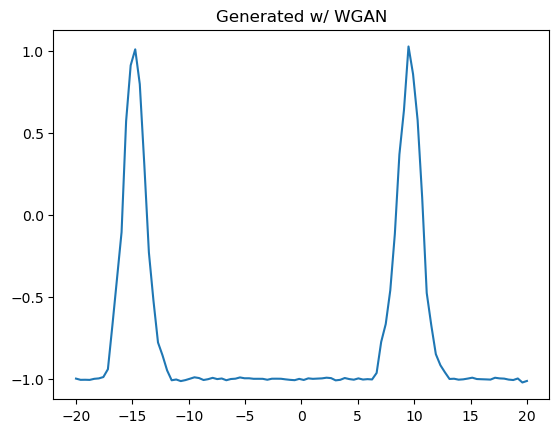

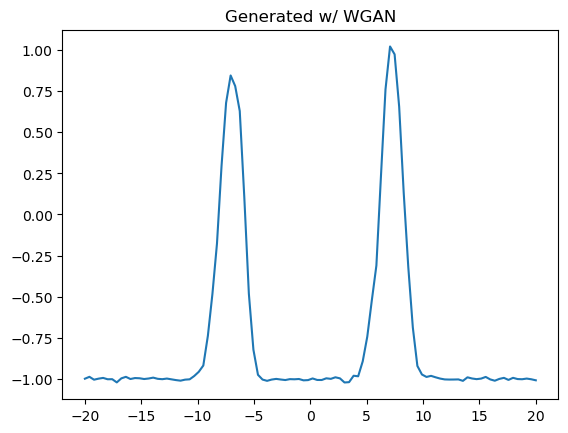

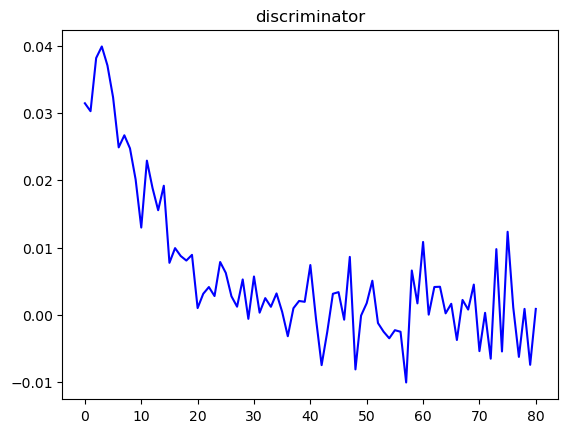

epoch= 81 	 time= 11.515 min 	 lr_d= 0.0000922 	 lr_g= 0.0000922 	 loss_d= -0.0036 	 loss_g= -237.35
epoch= 82 	 time= 11.655 min 	 lr_d= 0.0000922 	 lr_g= 0.0000922 	 loss_d= -0.0009 	 loss_g= -239.00
epoch= 83 	 time= 11.796 min 	 lr_d= 0.0000876 	 lr_g= 0.0000876 	 loss_d= 0.00576 	 loss_g= -241.06
epoch= 84 	 time= 11.937 min 	 lr_d= 0.0000876 	 lr_g= 0.0000876 	 loss_d= 0.00132 	 loss_g= -242.74
epoch= 85 	 time= 12.075 min 	 lr_d= 0.0000832 	 lr_g= 0.0000832 	 loss_d= 0.00390 	 loss_g= -244.26
epoch= 86 	 time= 12.213 min 	 lr_d= 0.0000832 	 lr_g= 0.0000832 	 loss_d= 0.00848 	 loss_g= -245.18
epoch= 87 	 time= 12.352 min 	 lr_d= 0.0000791 	 lr_g= 0.0000791 	 loss_d= -0.0041 	 loss_g= -246.19
epoch= 88 	 time= 12.490 min 	 lr_d= 0.0000791 	 lr_g= 0.0000791 	 loss_d= 0.00473 	 loss_g= -247.98
epoch= 89 	 time= 12.631 min 	 lr_d= 0.0000751 	 lr_g= 0.0000751 	 loss_d= 0.00154 	 loss_g= -248.90
epoch= 90 	 time= 12.769 min 	 lr_d= 0.0000751 	 lr_g= 0.0000751 	 loss_d= -0.0076 	 loss_g

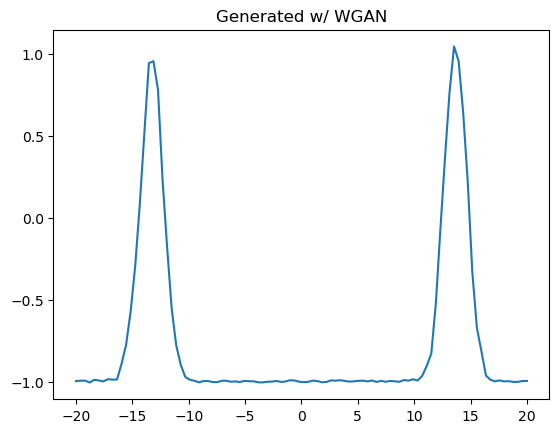

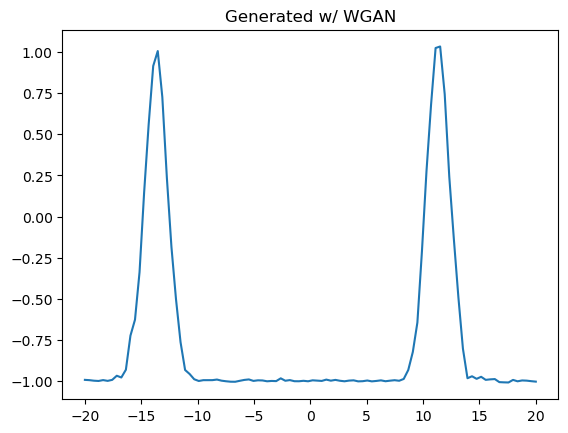

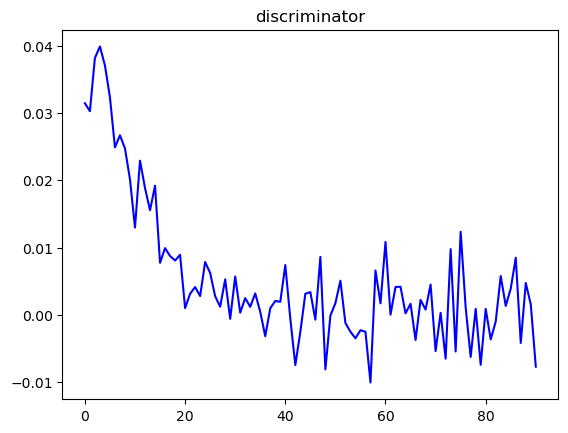

epoch= 91 	 time= 12.914 min 	 lr_d= 0.0000713 	 lr_g= 0.0000713 	 loss_d= 0.00330 	 loss_g= -251.24
epoch= 92 	 time= 13.053 min 	 lr_d= 0.0000713 	 lr_g= 0.0000713 	 loss_d= -0.0097 	 loss_g= -251.86
epoch= 93 	 time= 13.194 min 	 lr_d= 0.0000678 	 lr_g= 0.0000678 	 loss_d= 0.00445 	 loss_g= -252.58
epoch= 94 	 time= 13.334 min 	 lr_d= 0.0000678 	 lr_g= 0.0000678 	 loss_d= 0.00500 	 loss_g= -253.51
epoch= 95 	 time= 13.473 min 	 lr_d= 0.0000644 	 lr_g= 0.0000644 	 loss_d= 0.00297 	 loss_g= -254.67
epoch= 96 	 time= 13.619 min 	 lr_d= 0.0000644 	 lr_g= 0.0000644 	 loss_d= 0.00149 	 loss_g= -255.64
epoch= 97 	 time= 13.766 min 	 lr_d= 0.0000612 	 lr_g= 0.0000612 	 loss_d= -0.0048 	 loss_g= -256.49
epoch= 98 	 time= 13.914 min 	 lr_d= 0.0000612 	 lr_g= 0.0000612 	 loss_d= -0.0052 	 loss_g= -257.24
epoch= 99 	 time= 14.062 min 	 lr_d= 0.0000581 	 lr_g= 0.0000581 	 loss_d= -0.0045 	 loss_g= -257.42


In [56]:
# Training loop
del net
net = WGAN()
net = net.to(device)
_ = display_num_param(net)

# Optimizer
list_param = []
for p in net.generator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_gen = nn.ParameterList(list_param)
list_param = []
for p in net.discriminator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_dis = nn.ParameterList(list_param)
init_lr = 0.0003
optimizer_g = torch.optim.Adam(params_gen, lr=init_lr, betas=(0.0, 0.9))
optimizer_d = torch.optim.Adam(params_dis, lr=init_lr, betas=(0.0, 0.9))

scheduler_d = optim.lr_scheduler.ReduceLROnPlateau(optimizer_d, mode='min', factor=0.95, patience=1, verbose=True)

print('dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs : ', \
      dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs)

# Number of mini-batches per epoch
nb_epochs = 100
run_every_k_steps = 5

list_loss_dis = []
list_loss_gen = []

start = time.time()
for epoch in range(nb_epochs):

    running_loss_d = 0.0
    running_loss_g = 0.0
    num_batches = 0

    net.train()
    
    shuffled_indices = torch.randperm(N)
    for count in range(0,N,bs):

        # discriminator update
        idx_real = shuffled_indices[count : count+bs]
        x_real = train_data[idx_real,:].to(device) # [bs, n]
        z = torch.rand(bs, dz).to(device)          # [bs, dz]    
        x_fake = net.forward_gen(z)                # [bs, n]
        fake_discr = net.forward_dis(x_fake)       # [bs, 1]    
        real_discr = net.forward_dis(x_real)       # [bs, 1]
        loss = fake_discr.mean() - real_discr.mean()
        epsilon = torch.FloatTensor(bs, 1).uniform_(0, 1).to(device)
        x_hat = epsilon * x_fake + (1 - epsilon) * x_real
        xhat_discr = net.forward_dis(x_hat)
        grads = torch.autograd.grad(xhat_discr, x_hat, grad_outputs=torch.ones_like(xhat_discr), create_graph=True)[0]
        penalty = ((torch.sqrt((grads ** 2).sum(1)) - 1) ** 2).mean()
        loss = loss + 10 * penalty
        running_loss_d = -loss.detach().cpu().item() 
        optimizer_d.zero_grad()
        loss.backward()
        optimizer_d.step()

        # generator update
        if count % run_every_k_steps == 0:
            z = torch.rand(bs, dz).to(device) # [bs, dz]
            loss = - net.forward_dis(net.forward_gen(z)).mean()
            optimizer_g.zero_grad()
            loss.backward()
            optimizer_g.step()
        running_loss_g += loss.detach().cpu().item() 

        # Compute stats
        num_batches += 1


    # Average stats
    mean_loss_d = running_loss_d/ num_batches
    mean_loss_g = running_loss_g/ num_batches
    if epoch>25:
        scheduler_d.step(mean_loss_d)
        optimizer_g.param_groups[0]['lr'] = optimizer_d.param_groups[0]['lr']
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', str(elapsed)[:6],'min', '\t lr_d=', '{:.7f}'.format(optimizer_d.param_groups[0]['lr']) , \
          '\t lr_g=', '{:.7f}'.format(optimizer_g.param_groups[0]['lr']) , \
          '\t loss_d=', str(mean_loss_d)[:7] ,'\t loss_g=', str(mean_loss_g)[:7] )
    list_loss_dis.append(mean_loss_d)
    list_loss_gen.append(mean_loss_g)

    # Plot intermediate generated data
    if not epoch%10 and epoch>0:
        plt.plot(x, x_fake[0].detach().cpu()); plt.title("Generated w/ WGAN"); plt.show()
        plt.plot(x, x_fake[1].detach().cpu()); plt.title("Generated w/ WGAN"); plt.show()
        plt.plot(torch.tensor(list_loss_dis),'b-'); plt.title('discriminator'); plt.show() 
        # plt.plot(torch.tensor(list_loss_gen),'g-'); plt.title('generator'); plt.show() 

    # Check lr value
    if optimizer_d.param_groups[0]['lr'] < 10**-5: 
      print("\n lr is equal to min lr -- training stopped\n")
      break




# Generate new data

batch_x_0 torch.Size([16, 100])


<Figure size 1280x960 with 0 Axes>

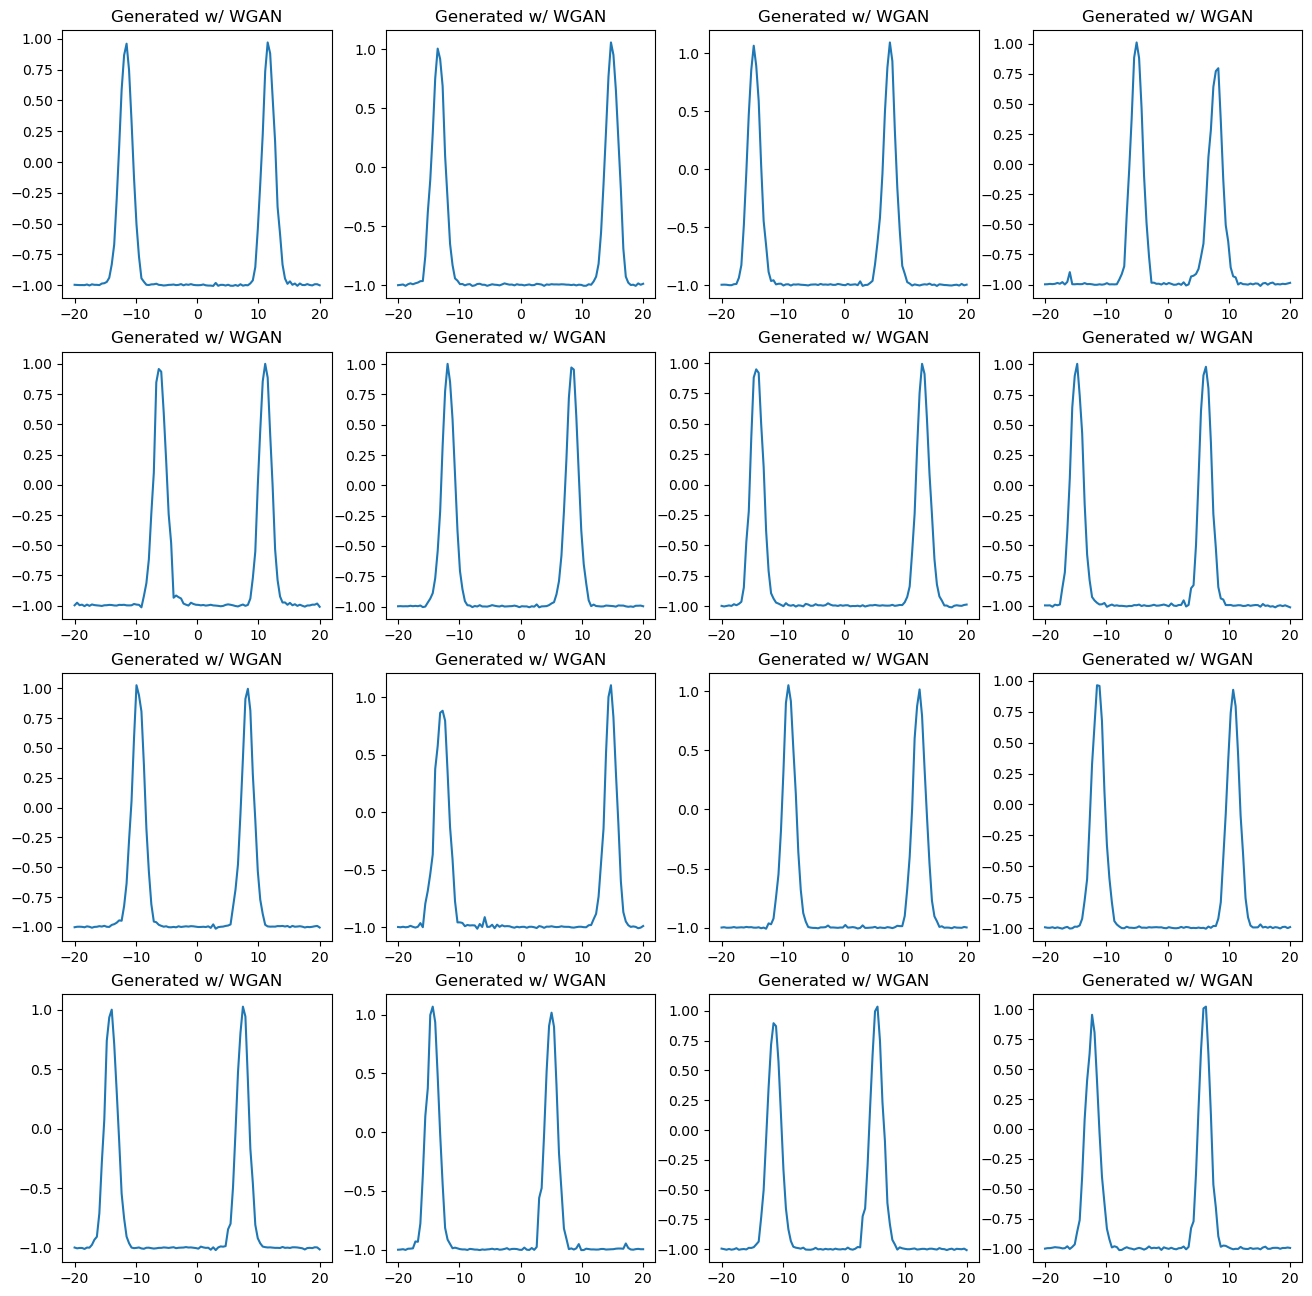

In [57]:
net.eval()
with torch.no_grad():
    num_generated_images = 16
    z = torch.rand(num_generated_images, dz).to(device) # [bs, dz]
    batch_x_0 = net.forward_gen(z) # [bs, n]
    print('batch_x_0',batch_x_0.size())
    batch_x_0 = batch_x_0.cpu()

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,0,1; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,0,2; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,0,3; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,1+0,4; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,1+0,5; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,1+0,6; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,1+0,7; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,2+0,8; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,2+0,9; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,2+0,10; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,2+0,11; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,3+0,12; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,3+0,13; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,3+0,14; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,3+0,15; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
plt.show()
